# Machine Learning Exercise 5 - Regularized Linear Regression and Bias vs. Variance
Programming exercise for Andrew Ng's Machine Learning Class on Coursera written in python 3.4.

## Regularized Linear Regression

Task: implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io    # used to read matlab data file in .mat format.
import seaborn as sns
from scipy.optimize import minimize
%matplotlib inline
np.set_printoptions(precision=4, suppress=True)
sns.set_style('white')

In [2]:
# load data
mat = scipy.io.loadmat('./machine-learning-ex5/ex5/ex5data1.mat')    # scipy.io.loadmat loads .mat file into a dict
train = pd.DataFrame(np.c_[mat['X'], mat['y']], columns=['X', 'y'])
cv = pd.DataFrame(np.c_[mat['Xval'], mat['yval']], columns=['Xval', 'yval'])
test = pd.DataFrame(np.c_[mat['Xtest'], mat['ytest']], columns=['Xtest', 'ytest'])

### Data Visualization

In [3]:
def plotRawData(f, a):
    """
    Plots the raw data. 
    input: fig, ax
    output: a scatter plot
    """
    a.scatter('X', 'y', c='r', marker='x', s=50, data=train, linewidths=2)
    a.set_xlabel('Change in water level (x)', fontsize=20)
    a.set_ylabel('Water flowing out of the dam (y)', fontsize=20)

### Cost Function Regularization

In [4]:
def h(theta, X):
    """
    Computes the predicted value h
    input: theta, X as ndarrays. X should have x0's
    output: a vector of predicted values
    """
    return X.dot(theta)

In [5]:
def array_with_ones(X):
    """
    Adds x0's to the features.
    input: ndarray;
    output: same array with ones inserted to the first column.
    """
    return np.c_[np.ones(X.shape[0]), X]

In [6]:
def linearRegCostFunction(theta, X, y, reg=0):
    """
    Computes the cost function for linear regression.
    input: theta, X, y as ndarrays, reg=0;
    output: a number.
    """
    hh = h(theta, X)
    return np.sum((hh - y)**2) / (2*X.shape[0]) + (reg/(2*X.shape[0])) * np.sum(theta**2)

In [7]:
def gradient(theta, X, y, reg=0):
    """
    Computes the gradient of cost function.
    input: theta, X, y as ndarrays, reg=0;
    output: a number.
    """
    hh = h(theta, X)
    g = (1/X.shape[0]) * (hh - y).dot(X) + (reg/X.shape[0]) * theta
    g[0] = ((1/X.shape[0]) * (hh - y).dot(X))[0]
    return g

In [8]:
init_theta = np.array([1, 1],)    #initialize theta
cost = linearRegCostFunction(init_theta, array_with_ones(train['X'].values), train['y'].values)
grad = gradient(init_theta, array_with_ones(train['X'].values), train['y'].values)
cost, grad

(303.95152555359761, array([ -15.303 ,  598.1674]))

In [9]:
def trainLinearReg(theta, X, y, reg=0):
    """
    Minimizes the cost function by optimizing theta.
    input: theta, X, y as ndarrays, reg=0
    output: computation results. _.x: optimized theta, _.fun: cost function value.
    """
    return minimize(linearRegCostFunction, theta, args=(X, y, reg), jac=gradient)

In [10]:
result = trainLinearReg(init_theta, array_with_ones(train['X'].values), train['y'].values)
print(result.message)
print('Cost function = ', result.fun)
print('theta = ', result.x)

Optimization terminated successfully.
Cost function =  22.373906495108915
theta =  [ 13.0879   0.3678]


(-50, 40)

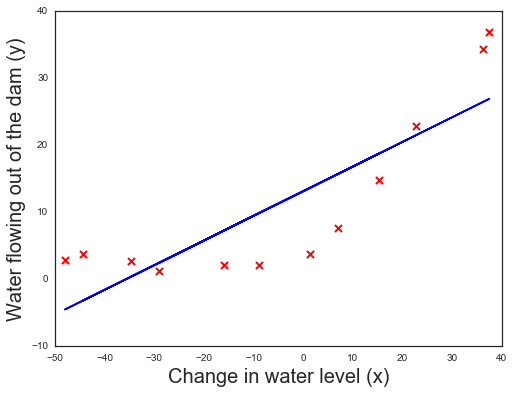

In [11]:
# Plotting the raw data
predicted = h(result.x, array_with_ones(train['X'].values))

fig1, ax1 = plt.subplots(figsize=(8, 6))
plotRawData(fig1, ax1)
ax1.plot(train['X'], predicted, 'b-')
ax1.set_xlim(-50, 40)

## Bias-variance

### Learning Curves

In [12]:
# returns a vector of errors for the training and CV sets.
def learningCurve (theta_init, train_x, cv_x, reg=0):
    """
    Computes training and cv errors with increasing number of examples
    input: theta_init, train_x, cv_x as  ndarrays, reg=0;
    output: vector of errors for training set, vector of errors for cv set in a tuple
    """
    error_train = []
    error_val = []
    for m in range(train.shape[0]):
        result = trainLinearReg(theta_init, train_x[:m+1], train['y'][:m+1].values, reg)
        error_train.append(result.fun)
        error_val.append(linearRegCostFunction(result.x, cv_x, cv['yval'].values, reg))
    
    return error_train, error_val

In [13]:
def plotJ(theta_init, train_x, cv_x, ax, reg=0):
    """
    Plots training and cv errors vs. number of examples.
    intput: theta_init, train_x, cv_x in ndarrays, ax
    """
    m = np.linspace(1, train_x.shape[0], train_x.shape[0])
    J_train, J_cv = learningCurve(theta_init, train_x, cv_x, reg)
    ax.plot(m, J_train, c='b', label='Train')
    ax.plot(m, J_cv, c='g', label='Cross Validation')
    ax.legend(loc='best', frameon=True)
    ax.set_title('Learning curve for linear regression', fontsize=16)
    ax.set_ylabel('Error', fontsize=14)
    ax.set_xlabel('Number of training examples', fontsize=14)

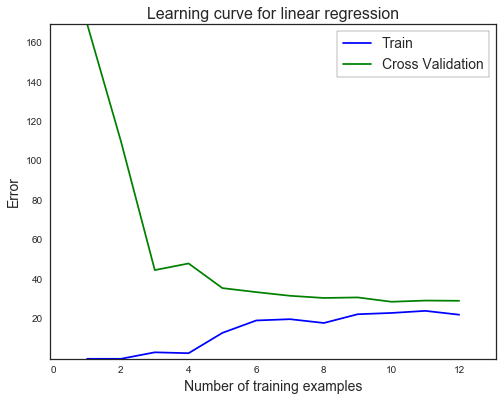

In [14]:
# Plotting training and CV erros vs. number of examples
fig2, ax2 = plt.subplots(figsize=(8, 6))
plotJ(init_theta, array_with_ones(train['X'].values), array_with_ones(cv['Xval'].values), ax2)
ax2.margins(0.1, 0)
ax2.legend(loc=1, fontsize=14, frameon=True)

### Adding polynomial features (high bias)

In [15]:
# no need to account for the 0th power in this function
def polyFeatures(X, p):
    """
    Adds powers from 1 to p to the input vector.
    input: vector, p in int;
    output: ndarray with p+1 columns from power 0 to p.
    """
    arr = X
    for power in range(1, p):
        arr = np.c_[arr, np.power(X, power+1)]
    return arr

In [16]:
def normal(X):
    """
    Normalize the input matrix with mean and std.
    input: ndarray for normalization.
    output: normalized ndarray with mean at 0 and range from -1 to 1.
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return ((X - mu) / std)

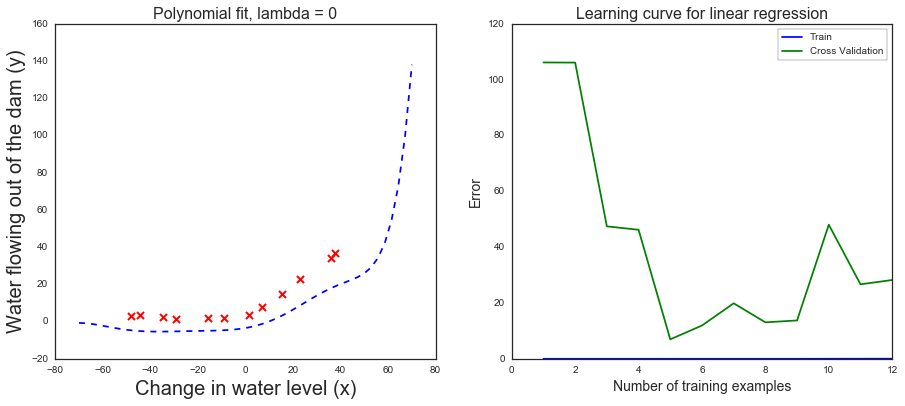

In [17]:
# Polynomialize the features then normalize them
p = 8    # raise x up to the 8th power.
train_poly = polyFeatures(train['X'].values, p)
cv_poly = polyFeatures(cv['Xval'].values, p)
train_norm = normal(train_poly)
cv_norm = normal(cv_poly)

# Plotting the polynormial regression.
fig3, ax3 = plt.subplots(1, 2, figsize=(15, 6))

X = np.linspace(-70, 70)
X_poly = polyFeatures(X, p)
X_norm = normal(X_poly)

init_theta_poly = np.ones(p+1)
theta_poly = trainLinearReg(init_theta_poly, array_with_ones(train_norm), train['y'].values).x

plotRawData(fig3, ax3[0])
pred_poly = h(theta_poly, array_with_ones(X_norm))
ax3[0].plot(X, pred_poly, 'b--')
ax3[0].set_title('Polynomial fit, lambda = 0', fontsize=16)

plotJ(init_theta_poly, array_with_ones(train_norm), array_with_ones(cv_norm), ax=ax3[1])

With no regularization, polynomial features minimizes training error, while CV error remains significant at small number of examples.

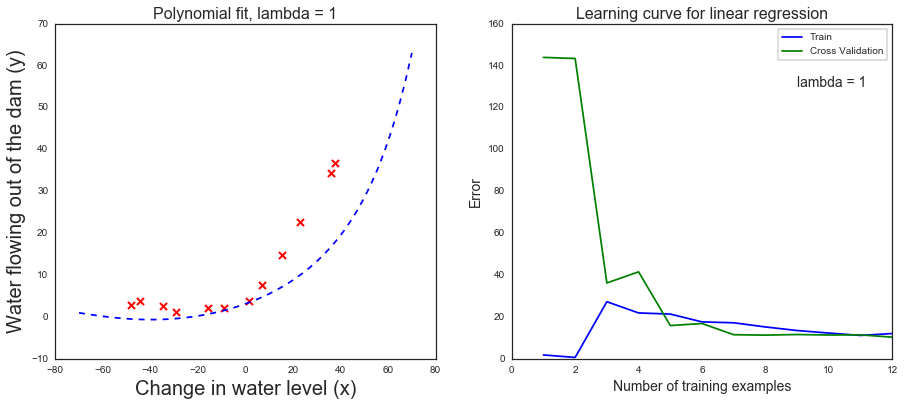

In [18]:
# now compute the case when lambda = 1
fig5, ax5 = plt.subplots(1, 2, figsize=(15,6))
plotRawData(fig5, ax5[0])

reg1 = 1
outcome_reg1 = trainLinearReg(init_theta_poly, array_with_ones(train_norm), train['y'], reg=reg1)
pred_poly_reg = h(outcome_reg1.x, array_with_ones(X_norm))
ax5[0].plot(X, pred_poly_reg, 'b--')
ax5[0].set_title('Polynomial fit, lambda = {}'.format(reg1), fontsize=16)
plotJ(init_theta_poly, array_with_ones(train_norm), array_with_ones(cv_norm), ax5[1], reg1)
ax5[1].text(9, 130, 'lambda = {}'.format(reg1), fontsize=14)

With some regularization (lambda = 1), both training and CV errors converge to a smaller value quickly.

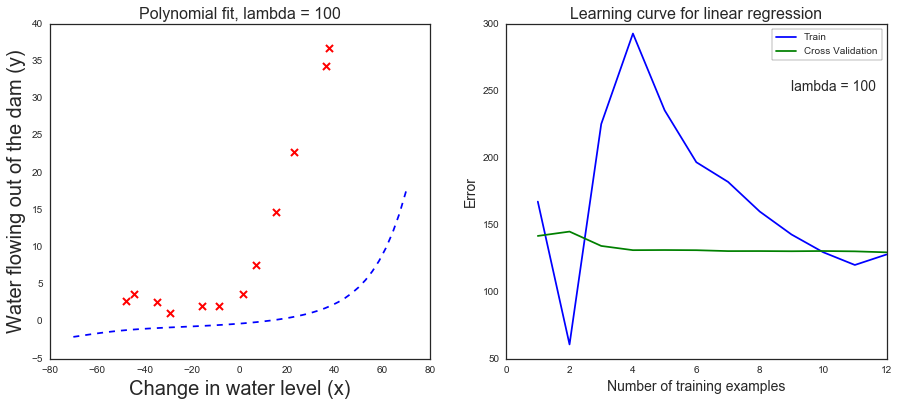

In [19]:
# now compute the case when lambda = 100
fig6, ax6 = plt.subplots(1, 2, figsize=(15,6))
plotRawData(fig6, ax6[0])

reg100 = 100
outcome_reg100 = trainLinearReg(init_theta_poly, array_with_ones(train_norm), train['y'], reg=reg100)
pred_poly_reg = h(outcome_reg100.x, array_with_ones(X_norm))
ax6[0].plot(X, pred_poly_reg, 'b--')
ax6[0].set_title('Polynomial fit, lambda = {}'.format(reg100), fontsize=16)
plotJ(init_theta_poly, array_with_ones(train_norm), array_with_ones(cv_norm), ax6[1], reg100)
ax6[1].text(9, 250, 'lambda = {}'.format(reg100), fontsize=14)

In [20]:
def validationCurve(theta, train_x, cv_x, regs):
    """
    Generates error vs. lambda curve for a list of lambda values.
    intput: theta, train_x, cv_x, in ndarrays, regs in list.
    output: error vs. lambda plot with training and CV datasets.
    """
    Js_tr = []
    Js_cv = []
    for reg in regs:
        res = trainLinearReg(theta, train_x, train['y'].values, reg=reg)
        params = res.x
        Js_tr.append(res.fun)
        Js_cv.append(linearRegCostFunction(params, cv_x, cv['yval'].values, reg=reg))
        
    return Js_tr, Js_cv

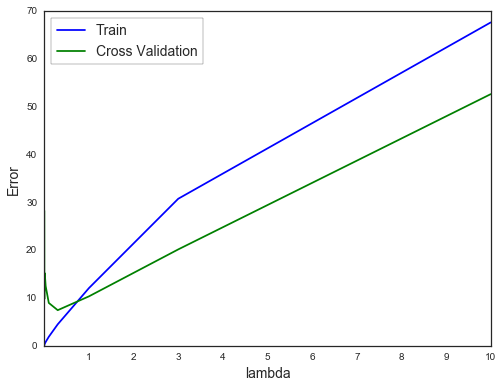

In [21]:
reg_list = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
err_tr, err_cv = validationCurve(init_theta_poly, array_with_ones(train_norm), array_with_ones(cv_norm), reg_list)

fig7, ax7 = plt.subplots(figsize=(8,6))
ax7.plot(np.array(reg_list), err_tr, 'b-', label='Train')
ax7.plot(np.array(reg_list), err_cv, 'g-', label='Cross Validation')
ax7.legend(loc='best', fontsize=14, frameon=True)
ax7.set_ylabel('Error', fontsize=14)
ax7.set_xlabel('lambda', fontsize=14)
ax7.set_xticks(np.linspace(1, 10, 10))

From the figure above, training and CV errors merge at lambda ~ 1.

## Solve by scikit-learn

In [22]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV

In [23]:
# load data
mat = scipy.io.loadmat('./machine-learning-ex5/ex5/ex5data1.mat')    # scipy.io.loadmat loads .mat file into a dict
train = pd.DataFrame(np.c_[mat['X'], mat['y']], columns=['X', 'y'])
cv = pd.DataFrame(np.c_[mat['Xval'], mat['yval']], columns=['Xval', 'yval'])
test = pd.DataFrame(np.c_[mat['Xtest'], mat['ytest']], columns=['Xtest', 'ytest'])

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


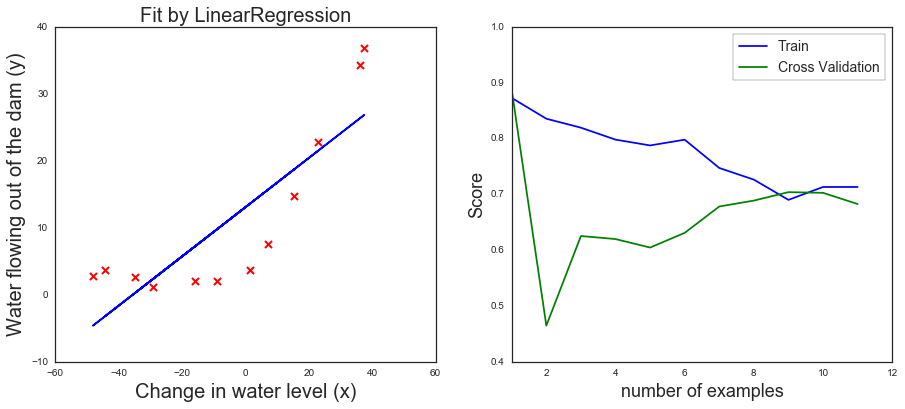

In [24]:
# fit data with univariate linear regression model, no regularization.
lm = LinearRegression()
lm.fit(train['X'].values.reshape(-1, 1), train['y'])
y = lm.predict(train['X'].values.reshape(-1, 1))

tr_scores = []
cv_scores = []
for m in range(1, train['y'].size+1):
    tr_scores.append(lm.score(train['X'][:m+1].values.reshape(-1, 1), train['y'][:m+1]))
    cv_scores.append(lm.score(cv['Xval'][:m+1].values.reshape(-1, 1), cv['yval'][:m+1]))

fig11, ax11 = plt.subplots(1, 2, figsize=(15, 6))
plotRawData(fig11, ax11[0])
ax11[0].plot(train['X'], y, 'b-')
ax11[1].plot(tr_scores, 'b-', label='Train')
ax11[1].plot(cv_scores, 'g-', label='Cross Validation')
ax11[1].set_xlabel('number of examples', fontsize=18)
ax11[0].set_title('Fit by LinearRegression', fontsize=20)
ax11[1].set_xlim(1, 12)
ax11[1].set_ylim(.4, 1)
ax11[1].set_ylabel('Score', fontsize=18)
ax11[1].legend(frameon=True, fontsize=14)

In [25]:
# transform data to polynomials
polynomial = PolynomialFeatures(p)
train_poly_ml = polynomial.fit_transform(train['X'].values.reshape(-1, 1))
cv_poly_ml = polynomial.fit_transform(cv['Xval'].values.reshape(-1, 1))

normalize = StandardScaler()
train_norm_ml = normalize.fit_transform(train_poly_ml)
cv_norm_ml = normalize.fit_transform(cv_poly_ml)

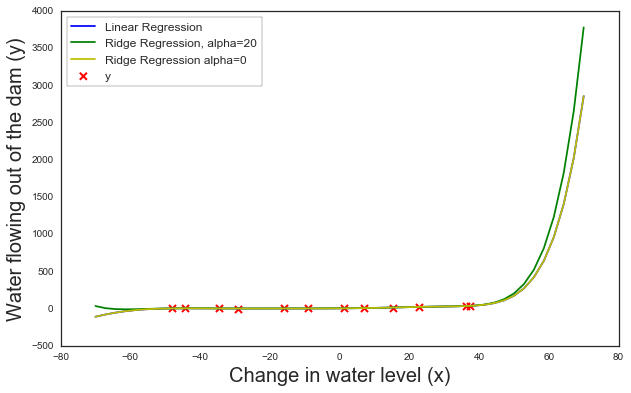

In [26]:
fig22, ax22 = plt.subplots(figsize=(10, 6))
plotRawData(fig22, ax22)

regr = LinearRegression()# Ordinary linear least squares.
ridge = Ridge(alpha=20) # Linear least squares with l2 regularization. alpha is regularization parameter.
ridge0 = Ridge(alpha=0)

xx = np.linspace(-70, 70)
xx_poly = polynomial.fit_transform(xx.reshape(-1, 1))
regr.fit(train_poly_ml, train['y'])
ridge.fit(train_poly_ml, train['y'])
ridge0.fit(train_poly_ml, train['y'])

ax22.plot(xx.reshape(-1, 1), regr.predict(xx_poly), 'b-', label='Linear Regression')
ax22.plot(xx.reshape(-1, 1), ridge.predict(xx_poly), 'g-', label='Ridge Regression, alpha=20')
ax22.plot(xx.reshape(-1, 1), ridge0.predict(xx_poly), 'y-', label='Ridge Regression alpha=0')

ax22.legend(loc=2, fontsize=12, frameon=True)

(-2, 2)

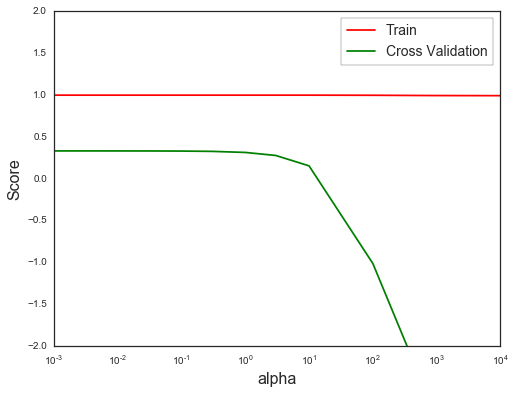

In [27]:
reg_list = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 100, 1000, 10000]

d = []
c = []
for a in reg_list:
    clf = Ridge(alpha=a)
    clf.fit(train_poly_ml, train['y'])
    tr_score = clf.score(train_poly_ml, train['y'])
    d.append(tr_score)
    cv_score = clf.score(cv_poly_ml, cv['yval'])
    c.append(cv_score)

plt.subplots(figsize=(8, 6))
plt.plot(reg_list, d, 'r-', label='Train')
plt.plot(reg_list, c, 'g-', label='Cross Validation')
plt.xscale('log')
plt.ylabel('Score', fontsize=16)
plt.xlabel('alpha', fontsize=16)
plt.legend(loc='best', fontsize=14, frameon=True)
plt.ylim(-2, 2)

With sklearn packages, the training score (R^2) is always 1 regardless of alpha values; however, the CV scores go down as alpha increases, result of higher regularization.